<a href="https://colab.research.google.com/github/Pumafi/dl_spatial_gen_geol_facies/blob/main/test_gan_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from tensorflow import keras
from keras import layers

In [3]:
!python3 -m pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.3 MB/s eta 0:00:00


In [4]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [31]:
# data
dataset_name = "oxford_flowers102"
dataset_repetitions = 5
num_epochs = 1  # train for at least 50 epochs for good results
image_size = 64
# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 30
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

In [32]:
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

In [33]:
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

In [34]:
from abc import ABC, abstractmethod


class DiffusionSchedule(ABC):
    def __init__(self, start_log_snr, end_log_snr):
        assert (
            start_log_snr > end_log_snr
        ), "The starting SNR has to be higher than the final SNR."

        self.end_beta = 20
        self.start_beta = 0.1

        self.start_snr = tf.exp(start_log_snr)
        self.end_snr = tf.exp(end_log_snr)

        #self.start_noise_power = 1.0 / (1.0 + self.start_snr)
        #self.end_noise_power = 1.0 / (1.0 + self.end_snr)

    def __call__(self, diffusion_times):
        signal_powers = self.get_noise_powers(diffusion_times)
        signal_rates = tf.math.exp(signal_powers)

        noise_rates = (1 - signal_rates**2)**0.5


        # the signal and noise power will always sum to one
        #signal_powers = 1.0 - noise_powers

        # the rates are the square roots of the powers
        # variance**0.5 -> standard deviation
        #signal_rates = signal_powers**0.5
        #noise_rates = noise_powers**0.5


        return noise_rates, signal_rates

    @abstractmethod
    def get_noise_powers(self, diffusion_times):
        pass


class SignalStepLinearSchedule(DiffusionSchedule):
    # the ratio between next-step and current signal powers decreases approximately linearly to 1
    # similar to the "linear schedule" of DDPM https://arxiv.org/abs/2006.11239
    def get_noise_powers(self, diffusion_times):

        return -(self.end_beta - self.start_beta) / 4 * diffusion_times**2 - self.start_beta / 2 * diffusion_times

        #return 1.0 - (1.0 - self.start_noise_power) * (
        #    (1.0 - self.end_noise_power) / (1.0 - self.start_noise_power)
        #) ** (diffusion_times**2)

In [35]:
def ResidualBlock(width, attention):
    def forward(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)

        x = tfa.layers.GroupNormalization(groups=8)(x)
        x = keras.activations.swish(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)

        x = tfa.layers.GroupNormalization(groups=8)(x)
        x = keras.activations.swish(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)

        x = layers.Add()([residual, x])

        if attention:
            residual = x
            x = tfa.layers.GroupNormalization(groups=8, center=False, scale=False)(
                x
            )
            x = layers.MultiHeadAttention(
                num_heads=4, key_dim=width, attention_axes=(1, 2)
            )(x, x)

            x = layers.Add()([residual, x])

        return x

    return forward

def DownBlock(block_depth, width, attention):
    def forward(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width, attention)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return forward

def UpBlock(block_depth, width, attention):
    def forward(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width, attention)(x)
        return x

    return forward

In [36]:
def get_first_network(
    image_channel_size,
    block_depth,
    widths,
    attentions,
    patch_size,
):
    images = keras.Input(shape=(None, None, image_channel_size))


    y = layers.Conv2D(widths[-1], kernel_size=patch_size, strides=patch_size)(images)

    skips = []
    for width, attention in zip(widths[:-1], attentions[:-1]):
        y = DownBlock(block_depth, width, attention)([y, skips])

    for _ in range(block_depth):
        y = ResidualBlock(widths[-1], attentions[-1])(y)

    for width, attention in zip(widths[-2::-1], attentions[-2::-1]):
        y = UpBlock(block_depth, width, attention)([y, skips])

    y = layers.Conv2DTranspose(
        image_channel_size, kernel_size=patch_size, strides=patch_size, kernel_initializer="zeros", activation="softmax"
    )(y)

    return keras.Model(images, y, name="original_uresnet")

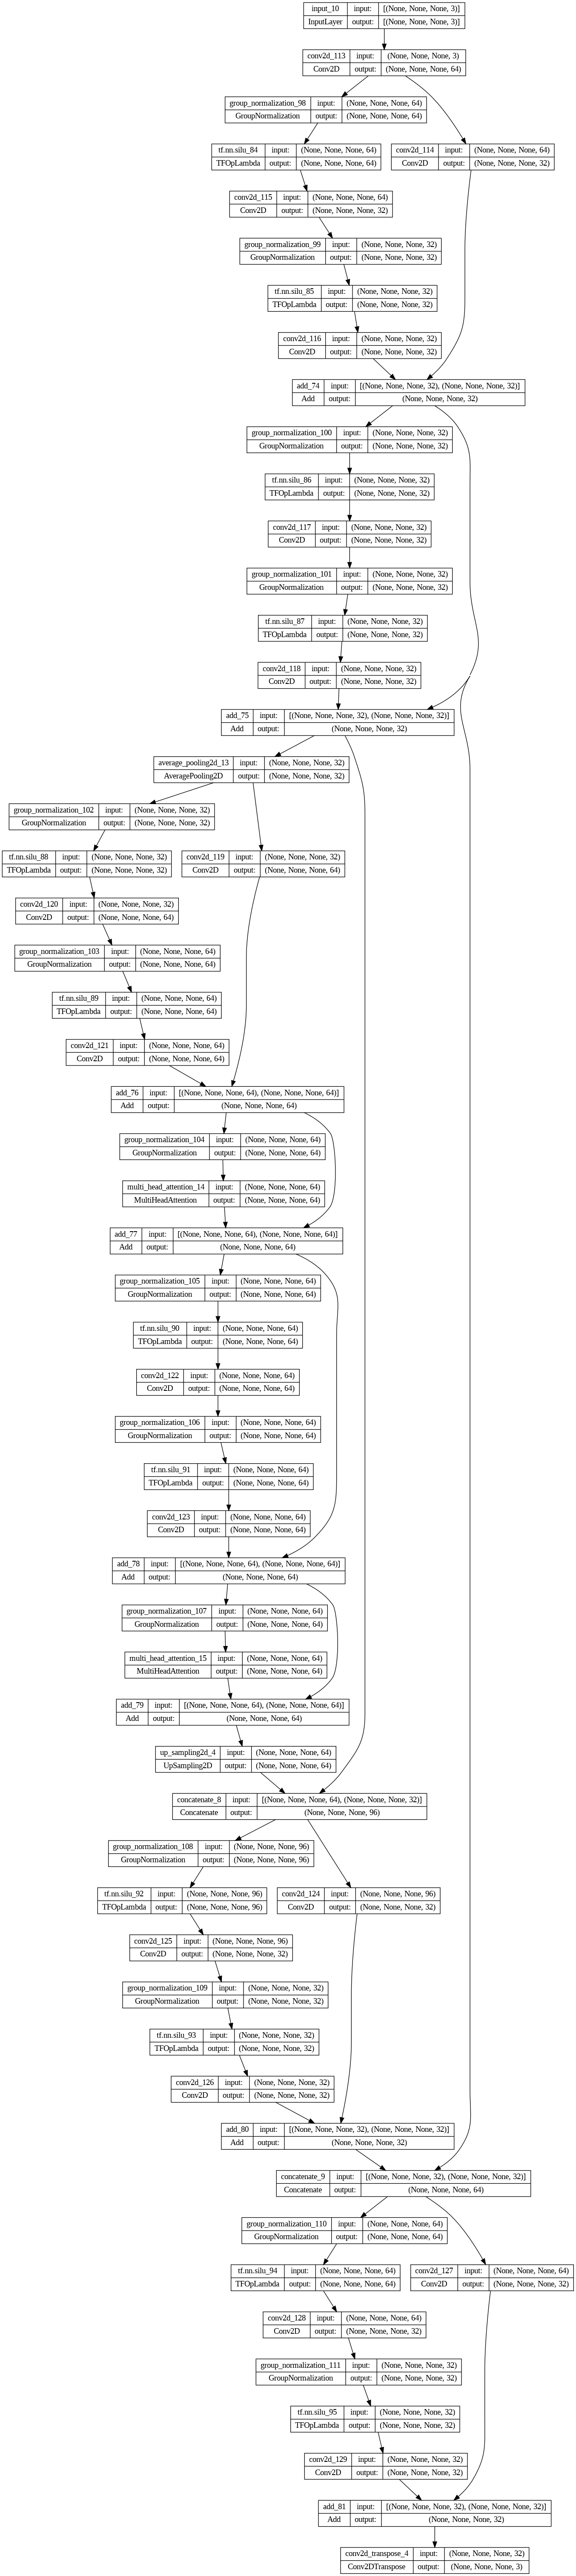

In [37]:
from keras.utils.vis_utils import plot_model
test_network = get_first_network(3, 2, [32, 64], [False, False, True], 1)
plot_model(test_network, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [38]:
def grow_generator(old_model, image_channel_size, block_depth, widths, attentions, patch_size):
    old_output = old_model.layers[-1].output

    y = layers.Conv2D(widths[-1], kernel_size=patch_size, strides=patch_size)(old_output)

    skips = []
    for width, attention in zip(widths[:-1], attentions[:-1]):
        y = DownBlock(block_depth, width, attention)([y, skips])

    for _ in range(block_depth):
        y = ResidualBlock(widths[-1], attentions[-1])(y)

    for width, attention in zip(widths[-2::-1], attentions[-2::-1]):
        y = UpBlock(block_depth, width, attention)([y, skips])

    y = layers.Conv2DTranspose(
        image_channel_size, kernel_size=patch_size, strides=patch_size, kernel_initializer="zeros", activation="softmax"
    )(y)

    model = tf.keras.Model(inputs=old_model.input, outputs=y, name = "grown_resnet")

    return model

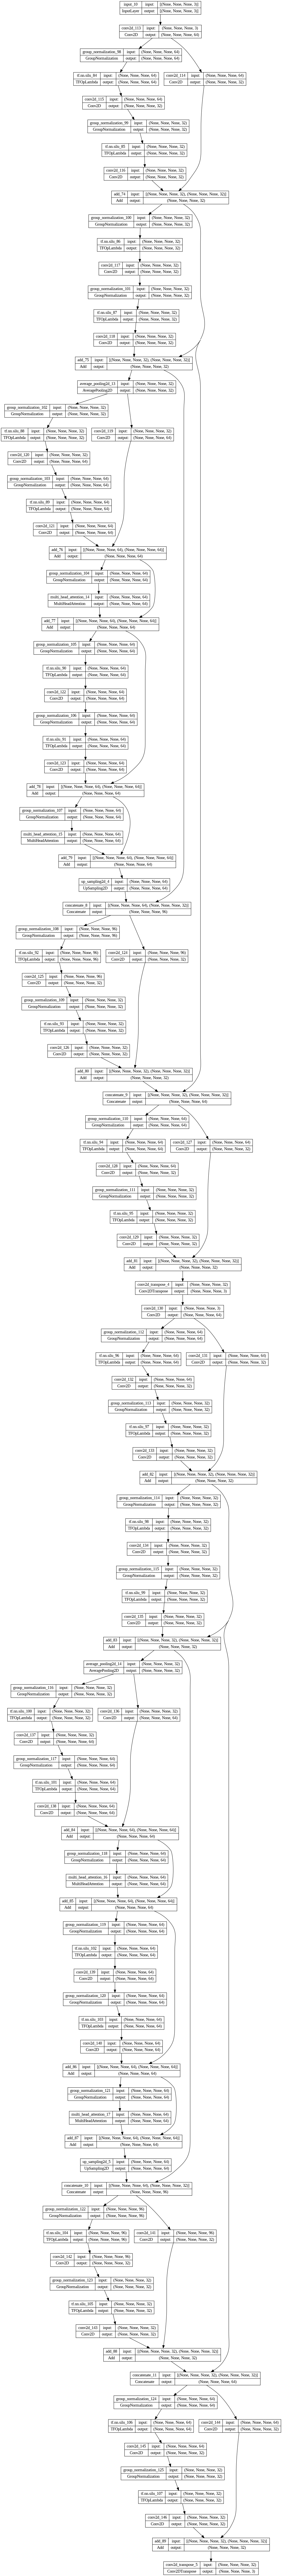

In [39]:
from keras.utils.vis_utils import plot_model
test_network = grow_generator(test_network, 3, 2, [32, 64], [False, False, True], 1)
plot_model(test_network, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
def DiscResidualBlock(width, attention):
    def forward(x):
        x, n = x
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)

        n = layers.Dense(width)(n)

        x = tfa.layers.GroupNormalization(groups=8)(x)
        x = keras.activations.swish(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)

        x = layers.Add()([x, n])

        x = tfa.layers.GroupNormalization(groups=8)(x)
        x = keras.activations.swish(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)

        x = layers.Add()([residual, x])

        if attention:
            residual = x
            x = tfa.layers.GroupNormalization(groups=8, center=False, scale=False)(
                x
            )
            x = layers.MultiHeadAttention(
                num_heads=4, key_dim=width, attention_axes=(1, 2)
            )(x, x)

            x = layers.Add()([residual, x])

        return x

    return forward

def DiscDownBlock(block_depth, width, attention):
    def forward(x):
        x, n, skips = x
        for _ in range(block_depth):
            x = DiscResidualBlock(width, attention)([x, n])
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return forward

def EmbeddingLayer(embedding_max_frequency, embedding_dims):
    def sinusoidal_embedding(x):
        embedding_min_frequency = 1.0
        frequencies = tf.exp(
            tf.linspace(
                tf.math.log(embedding_min_frequency),
                tf.math.log(embedding_max_frequency),
                embedding_dims // 2,
            )
        )
        angular_speeds = 2.0 * math.pi * frequencies
        embeddings = tf.concat(
            [
                tf.sin(angular_speeds * x),
                tf.cos(angular_speeds * x),
            ],
            axis=-1,
        )
        return embeddings

    def forward(x):
        x = layers.Lambda(sinusoidal_embedding)(x)
        return x

    return forward

In [41]:
import tensorflow as tf
from tensorflow import keras

class FinalDiscriminatorBlock(tf.keras.layers.Layer):
    def __init__(self, features, kernel_size_1=(3, 3), kernel_size_2=(4, 4), padding="same", name="final-disc-block"):
        super(FinalDiscriminatorBlock, self).__init__()

        self.batch_norm = tf.keras.layers.BatchNormalization(momentum=0.9)

        self.conv_1 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size_1,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.activations.swish,
                                             name=name + "-conv1")

        self.conv_2 = tf.keras.layers.Conv2D(filters=features, kernel_size=kernel_size_2,
                                             strides=(1, 1), padding=padding,
                                             activation=tf.keras.activations.swish,
                                             name=name + "-conv2")

        self.flat = tf.keras.layers.Flatten(name="disc-flatten-output")
        self.dense = tf.keras.layers.Dense(1, name="disc-dense-output", activation="sigmoid")

    def call(self, inputs):
        y = self.conv_1(inputs)
        y = self.conv_2(y)
        y = self.batch_norm(y)
        y = self.flat(y)
        y = self.dense(y)

        return y


def get_vanilla_discriminator_model(input_dims, widths, attentions, patch_size, noise_embedding_max_frequency, noise_embed_size):
    """
    Function that gives a vanilla discriminator model (fully convolutional), optionally with Gaussian Noise to the inputs
    Args:
        input_dims: dimensions of the images the discriminator must judge
        kernel_size: size of convolution kernel
        layers_features: an array with the number of features per layer
        add_noise: whether gaussian noise should be added
        (gaussian noise smooth the probability distribution supports and can help with training)

    Returns: the built discriminator model

    """
    if widths is None:
        widths = [16, 32, 64, 128, 256]

    padding = "same"

    x_high_res = tf.keras.layers.Input(shape=(input_dims[0], input_dims[1], input_dims[2]))
    noise_powers = keras.Input(shape=(1, 1, 1))
    n = EmbeddingLayer(noise_embedding_max_frequency, noise_embed_size)(
        noise_powers
    )
    n = layers.Dense(noise_embed_size, activation=keras.activations.swish)(n)
    n = layers.Dense(noise_embed_size, activation=keras.activations.swish)(n)

    y = layers.Conv2D(widths[0], kernel_size=patch_size, strides=patch_size)(x_high_res)

    skips = []
    for width, attention in zip(widths[:-1], attentions[:-1]):
        y = DiscDownBlock(block_depth, width, attention)([y, n, skips])


    y = FinalDiscriminatorBlock(widths[-1], kernel_size_1=(3, 3), padding=padding)(y)

    d_model = keras.models.Model([x_high_res, noise_powers], y, name="discriminator")
    return d_model

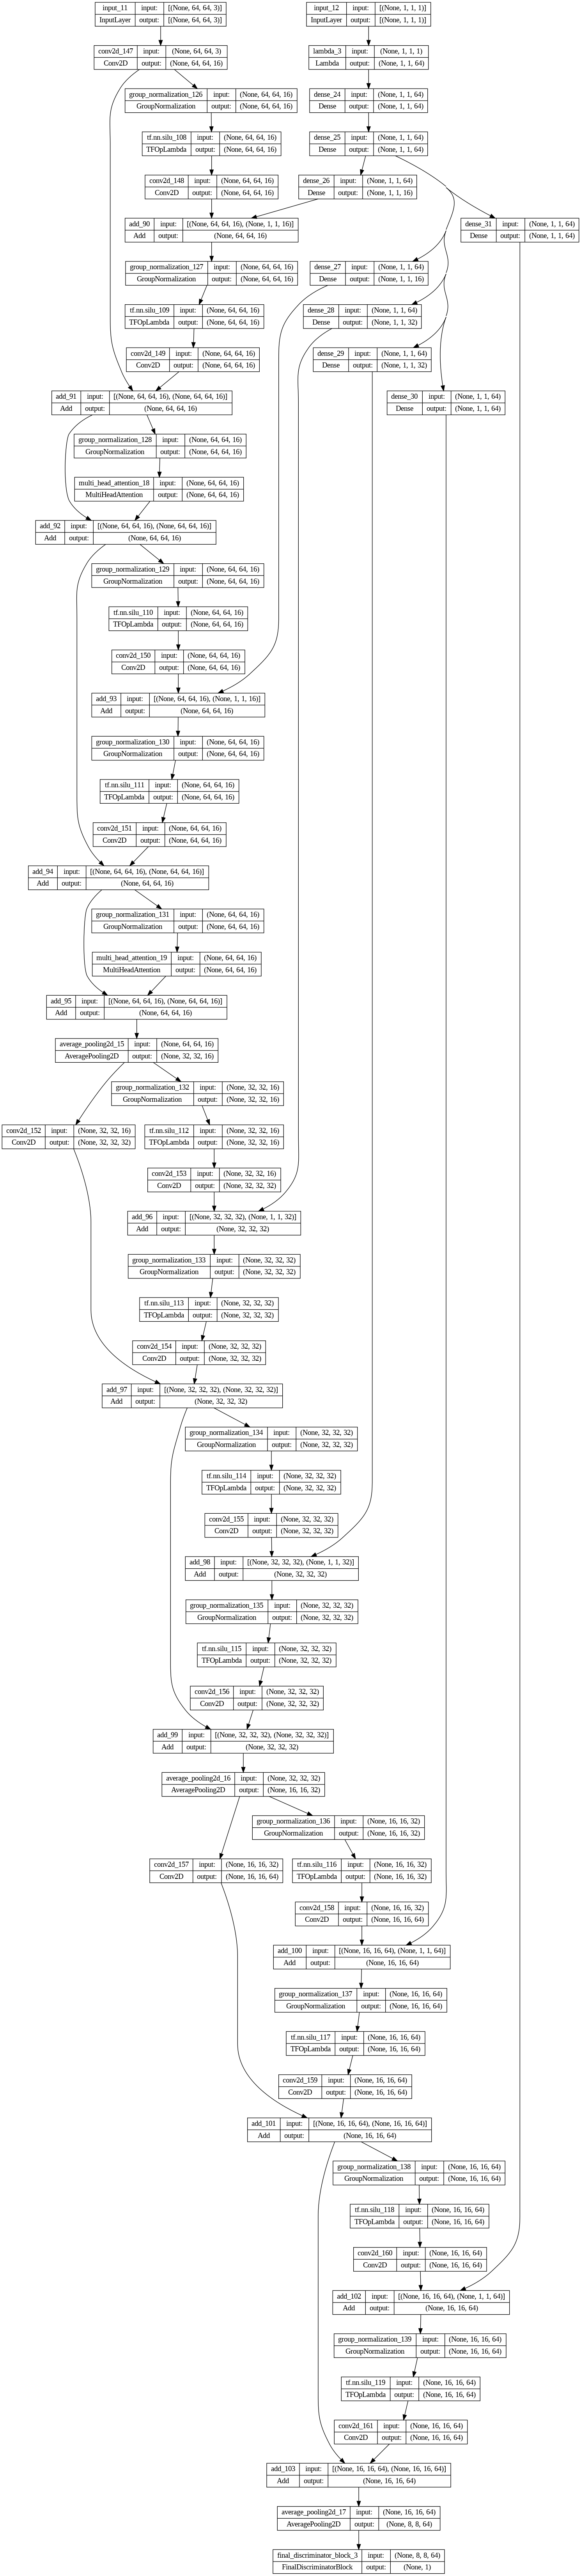

In [42]:
from keras.utils.vis_utils import plot_model
discriminator = get_vanilla_discriminator_model((image_size, image_size, 3), None, [True, False, False, False], 1, 1000., 64)
plot_model(discriminator, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [51]:
def discriminator_loss(real_img, fake_img):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_img), real_img)
    fake_loss = cross_entropy(tf.zeros_like(fake_img), fake_img)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_img):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_img), fake_img)


In [56]:
class DiffusionGan(tf.keras.Model):
    def __init__(self, images_shape, widths, block_depth, gen_lr=1e-4,
                 disc_lr=1e-4, batch_size=30, large_model=False):
        super().__init__()

        noise_embedding_max_frequency = 1000.0
        self.images_shape = images_shape
        self.noise_embedding_dims = 64
        self.block_depth = block_depth # 2
        self.d_steps = 2
        self.g_steps = 1

        self.widths = widths # [16, 32, 64, 128, 256]
        self.attentions = [False, False, True]

        self.patch_size = 1

        self.diffusion_schedule = SignalStepLinearSchedule(start_log_snr=3.0, end_log_snr=-10.0,)


        self.total_network = get_first_network(images_shape[-1], block_depth,
                                               self.widths[0:2], self.attentions, self.patch_size)


        # Growing Generator
        self.gen_optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=gen_lr)
        self.previous_network = None
        self.current_network = self.total_network
        self.batch_size = batch_size

        # Discriminator
        self.disc_optimiser = tf.keras.optimizers.legacy.Adam(learning_rate=disc_lr)
        self.discriminator = get_vanilla_discriminator_model(images_shape, [32, 64, 128, 256],
         [True, False, False, False], self.patch_size, noise_embedding_max_frequency, self.noise_embedding_dims)

        # Growing rate
        self.growth_epoch = 30
        self.current_epoch = 0
        self.current_growth_step = 0

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.gen_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def train_step(self, images):
        noise = tf.random.normal(shape=(self.batch_size, *self.images_shape))


        # Multi-step Noise Rates and Signal Rates computation
        diffusion_time = (len(self.widths) - self.current_growth_step) / len(self.widths)
        diffusion_times = diffusion_time * tf.ones((batch_size, 1, 1, 1), dtype=tf.float32)

        noise_rates, signal_rates = SignalStepLinearSchedule(start_log_snr=3.0, end_log_snr=-10.0,)(diffusion_times)

        # Maybe we'll train the previous model simultaneously, but not now
        noisy_images = signal_rates * images + noise_rates * noise

        for i in range(self.d_steps):
            # Training the discriminator first
            random_latent_vectors = tf.random.normal(shape=(self.batch_size, *self.images_shape))
            with tf.GradientTape() as tape:
                fake_images = self.total_network(random_latent_vectors, training=True)
                fake_logits = self.discriminator([fake_images, noise_rates**2], training=True)
                real_logits = self.discriminator([noisy_images, noise_rates**2], training=True)

                d_loss = discriminator_loss(real_img=real_logits, fake_img=fake_logits)

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.disc_optimiser.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        for i in range(self.g_steps):
            # Training the generator second
            random_latent_vectors = tf.random.normal(shape=(self.batch_size, *self.images_shape))
            with tf.GradientTape() as tape:
                generated_images = self.total_network(random_latent_vectors, training=True)
                gen_img_logits = self.discriminator([generated_images, noise_rates**2], training=True)
                g_loss = generator_loss(gen_img_logits)

            gen_gradient = tape.gradient(g_loss, self.total_network.trainable_variables)
            self.gen_optimiser.apply_gradients(zip(gen_gradient, self.total_network.trainable_variables))

        self.current_epoch += 1
        if self.current_epoch >= self.growth_epoch and len(self.widths) < self.current_growth_step:
            # Temporary
            self.total_network.trainable = False # Freezong the weights
            self.previous_network = self.total_network
            self.total_network = grow_generator(self.total_network, self.images_shape[-1], self.block_depth,
                                                self.widths[self.current_growth_step:self.current_growth_step+2],
                                                self.attentions, self.patch_size)
            self.current_epoch = 0
            self.current_growth_step += 1

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)


        return {m.name: m.result() for m in self.metrics}

In [57]:
widths = [16, 32, 64, 128, 256]
image_size = (64, 64, 3)
block_depth = 2
model = DiffusionGan(image_size, widths, block_depth)

In [58]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss= tf.keras.losses.CategoricalCrossentropy(),
)

In [ ]:
batch_size = 30
t_epochs_nb=120
history = model.fit(train_dataset, batch_size=batch_size, epochs=t_epochs_nb)

Epoch 1/120
